* Analytics Vidya Time Series Problem https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/

### Load Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [2]:
train_df = pd.read_csv('Train_SU63ISt.csv')

test_df = pd.read_csv('Test_0qrQsBZ.csv')

sample = pd.read_csv('sample_submission_LSeus50.csv')

### EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [4]:
train_df.set_index('Datetime',inplace=True)

In [5]:
test_df.set_index('Datetime', inplace=True)

In [6]:
dataparse = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y %H:%M")
train_df.index = train_df.index.map(dataparse)
test_df.index = test_df.index.map(dataparse)
train_df.head()

<ipython-input-6-b9df808c884e>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dataparse = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y %H:%M")


,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(train_df['Count'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -4.456561
p-value                     0.000235
# lags used                45.000000
# observations          18242.000000
critical value (1%)        -3.430709
critical value (5%)        -2.861698
critical value (10%)       -2.566854
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
train_df.index.freq = 'H'

In [10]:
train_df.index

DatetimeIndex(['2012-08-25 00:00:00', '2012-08-25 01:00:00',
               '2012-08-25 02:00:00', '2012-08-25 03:00:00',
               '2012-08-25 04:00:00', '2012-08-25 05:00:00',
               '2012-08-25 06:00:00', '2012-08-25 07:00:00',
               '2012-08-25 08:00:00', '2012-08-25 09:00:00',
               ...
               '2014-09-25 14:00:00', '2014-09-25 15:00:00',
               '2014-09-25 16:00:00', '2014-09-25 17:00:00',
               '2014-09-25 18:00:00', '2014-09-25 19:00:00',
               '2014-09-25 20:00:00', '2014-09-25 21:00:00',
               '2014-09-25 22:00:00', '2014-09-25 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=18288, freq='H')

In [11]:
train_df.drop('ID',axis=1, inplace=True)

In [12]:
result = seasonal_decompose(train_df['Count'],model='add')

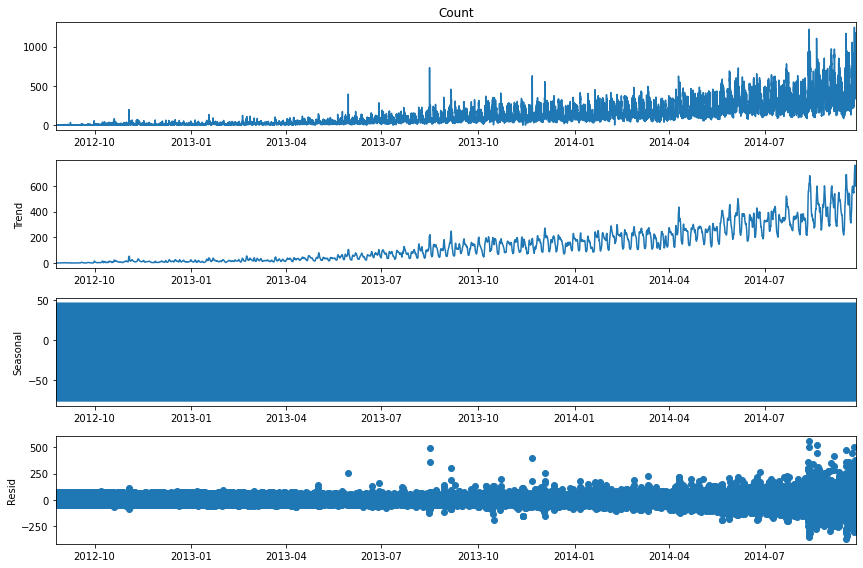

In [13]:
from pylab import rcParams
rcParams['figure.figsize']=(12,8)
result.plot();

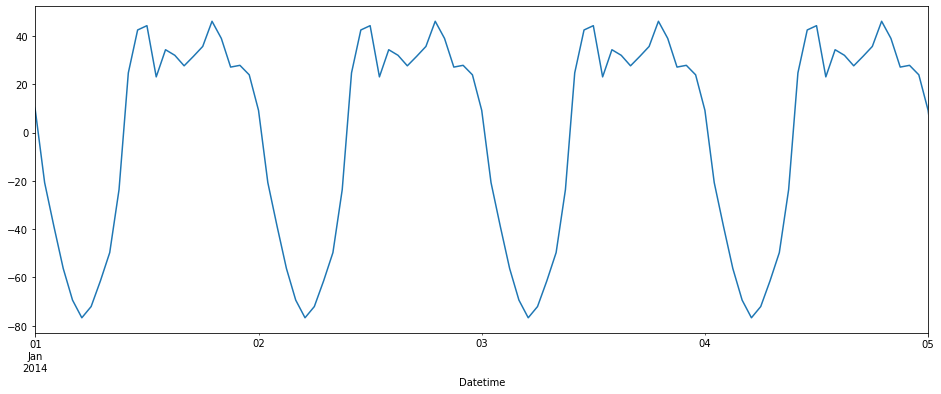

In [14]:
plt.figure(figsize=(16,6))
result.seasonal.plot()
plt.xlim('01-01-2014','01-05-2014');
#Looks like seasonality occurs 24 hours in a day

<AxesSubplot:xlabel='Datetime'>

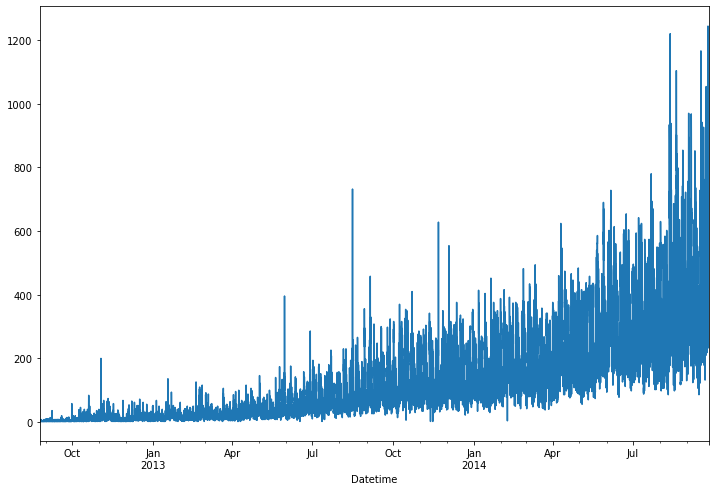

In [15]:
train_df['Count'].plot(figsize=(12,8))

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   18288 non-null  int64
dtypes: int64(1)
memory usage: 285.8 KB


In [19]:
step_wise = auto_arima(train_df['Count'], seasonal=False, trace =True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=187702.293, Time=6.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187752.233, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=187738.425, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=187739.699, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=187750.242, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=187703.352, Time=4.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=187702.880, Time=5.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=187706.868, Time=7.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=187706.097, Time=32.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187726.148, Time=7.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=35.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=187704.709, Time=7.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=49.87 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=187700.300, Time=2.65 sec
 ARIMA(1,1,2)(0,

In [20]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18288
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -93845.150
Date:                Fri, 23 Apr 2021   AIC                         187700.300
Time:                        23:05:39   BIC                         187739.369
Sample:                             0   HQIC                        187713.138
                              - 18288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6550      0.063    -10.367      0.000      -0.779      -0.531
ar.L2         -0.3887      0.059     -6.629      0.000      -0.504      -0.274
ma.L1          0.6833      0.062     10.935      0.000       0.561       0.806
ma.L2          0.4405      0.058      7.628      0.000       0.327       0.554
sigma2      1678.2805      5.572    301.213      0.000    1667.360    1689.201
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            335835.80
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              35.84   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

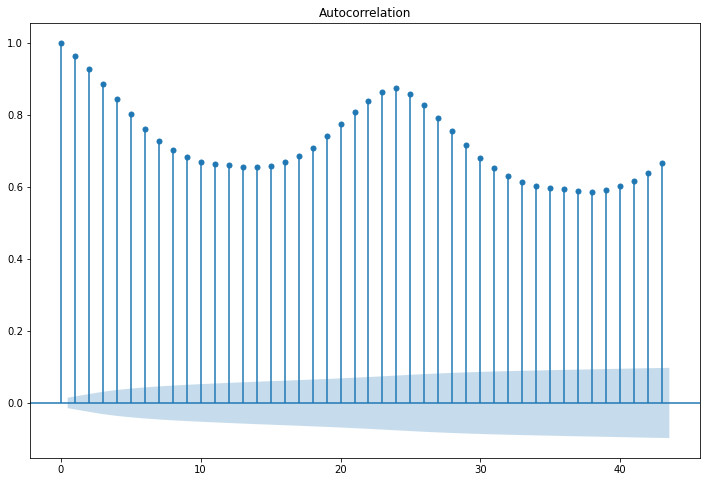

In [22]:
plot_acf(train_df['Count']);

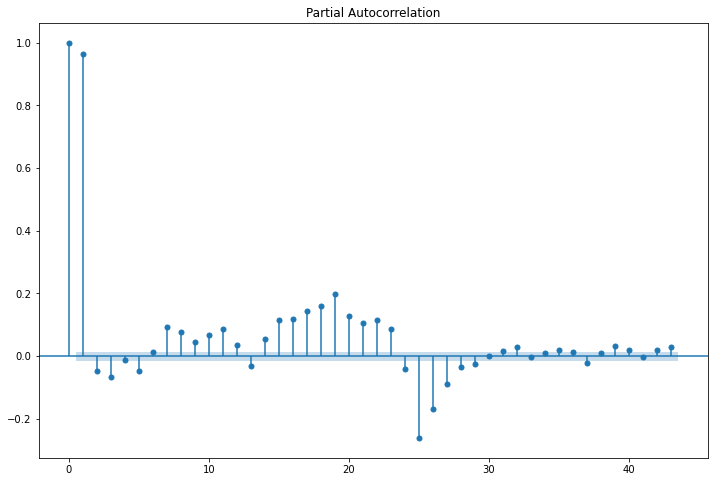

In [23]:
plot_pacf(train_df['Count']);

In [17]:
train_df.shape[0]-train_df.shape[0]/3

12192.0

In [18]:
X_train = train_df[:int(train_df.shape[0]-train_df.shape[0]/3)]

In [19]:
X_test = train_df[int(-train_df.shape[0]/3):]

In [20]:
X_train.shape, X_test.shape

((12192, 1), (6096, 1))

In [21]:
X_test.shape[0]+X_train.shape[0]

18288

In [22]:
model = ARIMA(X_train['Count'], order=(2,1,2))

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [23]:
result = model.fit()

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [24]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Count   No. Observations:                12191
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -55681.160
Method:                       css-mle   S.D. of innovations             23.297
Date:                Sat, 24 Apr 2021   AIC                         111374.319
Time:                        13:39:35   BIC                         111418.770
Sample:                    08-25-2012   HQIC                        111389.219
                         - 01-14-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0136      0.003      4.722      0.000       0.008       0.019
ar.L1.D.Count     0.4278      0.063      6.773      0.000       0.304       0.552
ar.L2.D.Count     0.3844      0.053      7.192      0.000       0.280       0.489
ma.L1.D.Count    -0.6389      0.065     -9.845      0.000      -0.766      -0.512
ma.L2.D.Count    -0.3587      0.065     -5.538      0.000      -0.486      -0.232
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1497           +0.0000j            1.1497            0.0000
AR.2           -2.2626           +0.0000j            2.2626            0.5000
MA.1            1.0018           +0.0000j            1.0018            0.0000
MA.2           -2.7832           +0.0000j            2.7832            0.5000
-----------------------------------------------------------------------------
"""

In [25]:
start = len(X_train)
end = len(X_train)+len(X_test)-1

In [26]:
start

12192

In [27]:
end

18287

In [28]:
test_pred = result.predict(start, end, typ='levels')

<AxesSubplot:xlabel='Datetime'>

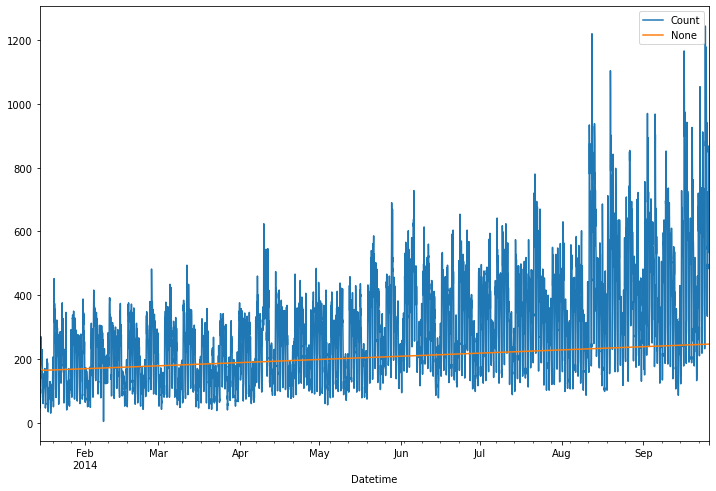

In [29]:
X_test['Count'].plot(figsize=(12,8),legend=True)
test_pred.plot(legend=True)

In [31]:
print('RMSE of ARIMA model',rmse(X_test['Count'],test_pred))
print('MAPE of ARIMA model', mean_absolute_percentage_error(X_test['Count'],test_pred))

RMSE of ARIMA model 173.94772635077177
MAPE of ARIMA model 0.44564308916927003


In [48]:
X_test['Count'].mean()

289.74114173228344

### Forecast

In [32]:
model = ARIMA(train_df['Count'], order=(2,1,2))
result = model.fit()

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.

In [52]:
start = len(train_df)
end = len(train_df) + len(test_df)-1

In [53]:
final_pred = result.predict(start, end, typ='levels')

<AxesSubplot:>

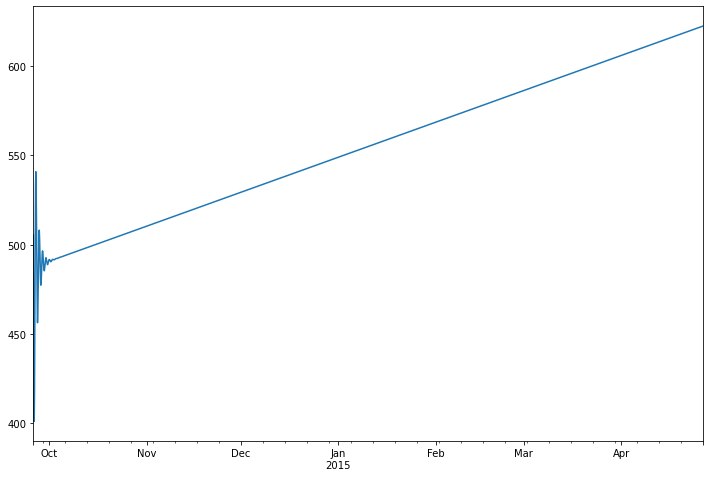

In [61]:
final_pred.plot()

In [59]:
sample['Count'] = final_pred.values

In [62]:
sample.to_csv('Time_series_ARIMA.csv', index=False)

### SARIMA

In [33]:
model_SA = SARIMAX(X_train['Count'],order=(0,1,0),seasonal_order=(2,0,2,24))

In [34]:
result = model_SA.fit()

In [69]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Count   No. Observations:                12192
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood              -55167.730
Date:                                 Fri, 23 Apr 2021   AIC                         110345.459
Time:                                         23:20:13   BIC                         110382.502
Sample:                                     08-25-2012   HQIC                        110357.876
                                          - 01-14-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.0705      1.021      0.069      0.945      -1.930       2.071
ar.S.L48       0.9268      1.019      0.909      0.363      -1.071       2.924
ma.S.L24      -0.0438      1.023     -0.043      0.966      -2.049       1.961
ma.S.L48      -0.9014      0.994     -0.907      0.365      -2.850       1.047
sigma2       497.3478      1.226    405.748      0.000     494.945     499.750
===================================================================================
Ljung-Box (L1) (Q):                1033.59   Jarque-Bera (JB):           1623910.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.70   Skew:                             1.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
start_sa = len(X_train)
end_sa = len(X_train)+len(X_test)-1

In [36]:
test_pred_SA = result.predict(start_sa,end_sa, typ='levels').rename('SARIMA pred')

(387192.0, 390264.0)

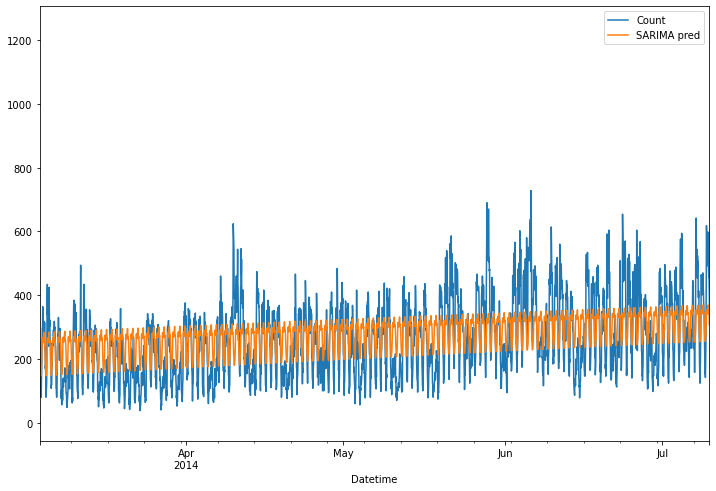

In [74]:
X_test.plot(figsize=(12,8), legend=True)
test_pred_SA.plot(legend=True)
plt.xlim('2014-03-04','2014-07-10')

In [37]:
print('RMSE of SARIMA model',rmse(X_test['Count'],test_pred_SA))
print('MAPE of SARIMA model', mean_absolute_percentage_error(X_test['Count'],test_pred_SA))

RMSE of SARIMA model 122.63574344197636
MAPE of SARIMA model 0.40160724050941815


In [76]:
X_test.mean()

Count    289.741142
dtype: float64

In [77]:
model_sa1 = SARIMAX(train_df['Count'],order=(0,1,0),seasonal_order=(2,0,2,24))

In [78]:
result = model_sa1.fit()

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Count   No. Observations:                18288
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood              -90350.359
Date:                                 Fri, 23 Apr 2021   AIC                         180710.717
Time:                                         23:27:04   BIC                         180749.787
Sample:                                     08-25-2012   HQIC                        180723.555
                                          - 09-25-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6750      0.109      6.180      0.000       0.461       0.889
ar.S.L48       0.3241      0.109      2.971      0.003       0.110       0.538
ma.S.L24      -0.5997      0.109     -5.516      0.000      -0.813      -0.387
ma.S.L48      -0.3401      0.103     -3.288      0.001      -0.543      -0.137
sigma2      1141.4001      3.918    291.357      0.000    1133.722    1149.078
===================================================================================
Ljung-Box (L1) (Q):                1096.57   Jarque-Bera (JB):            280372.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.74   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
start = len(train_df)

end = len(test_df)+len(train_df)-1

In [81]:
final_pred_sa = result.predict(start,end,typ='levels')

(394464.0, 394920.0)

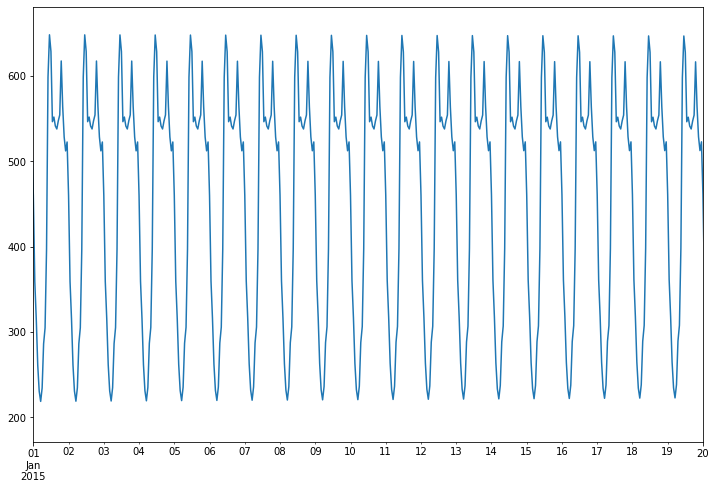

In [86]:
final_pred_sa.plot()
plt.xlim('2015-01-01','2015-01-20')

In [87]:
sample['Count'] = final_pred_sa.values

In [88]:
sample.to_csv('Time_series_SARIMA.csv', index=False)

### FB- Prophet

In [38]:
train_df.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [39]:
train_df.reset_index(inplace=True)

In [40]:
train_df.columns=['ds','y']

In [41]:
train_df.head()

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      18288 non-null  datetime64[ns]
 1   y       18288 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 285.9 KB


In [43]:
X_train = train_df[:int(train_df.shape[0]-train_df.shape[0]/3)]
X_test = train_df[-int(train_df.shape[0]/3):]

In [46]:
m = Prophet()
m.fit(X_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [47]:
len(X_test)

6096

In [48]:
future_df = m.make_future_dataframe(periods=6096, freq='H')

In [49]:
future_df.tail()

,ds
18283,2014-09-25 19:00:00
18284,2014-09-25 20:00:00
18285,2014-09-25 21:00:00
18286,2014-09-25 22:00:00
18287,2014-09-25 23:00:00


In [50]:
forecast = m.predict(future_df)

In [106]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2012-08-25 00:00:00,-48.022239,49.288944,3.580710
1,2012-08-25 01:00:00,-57.036639,39.535156,-8.653821
2,2012-08-25 02:00:00,-71.468693,19.188585,-21.543057
3,2012-08-25 03:00:00,-77.382849,14.064676,-31.782392
4,2012-08-25 04:00:00,-85.769808,6.781749,-38.173006
...,...,...,...,...
18283,2014-09-25 19:00:00,201.317321,342.531809,270.350241
18284,2014-09-25 20:00:00,200.647830,337.866174,268.032430
18285,2014-09-25 21:00:00,195.391994,337.155046,266.426346
18286,2014-09-25 22:00:00,198.608386,332.772683,265.225634


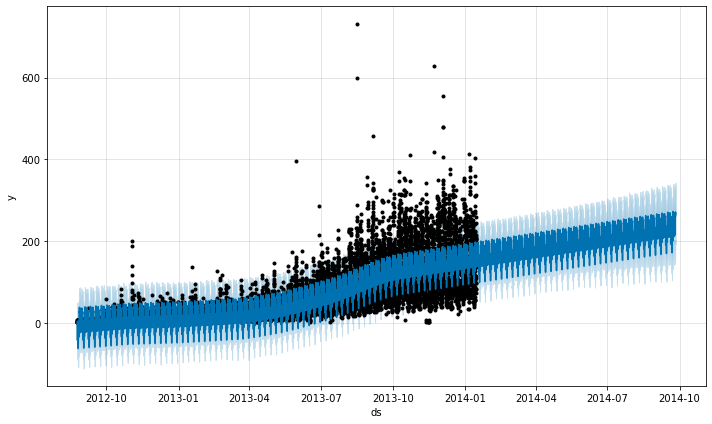

In [108]:
m.plot(forecast);

In [120]:
forecast.loc[12192:, ['ds','yhat']]

,ds,yhat
12192,2014-01-15 00:00:00,176.773059
12193,2014-01-15 01:00:00,165.351367
12194,2014-01-15 02:00:00,153.347681
12195,2014-01-15 03:00:00,144.064681
12196,2014-01-15 04:00:00,138.698321
...,...,...
18283,2014-09-25 19:00:00,270.350241
18284,2014-09-25 20:00:00,268.032430
18285,2014-09-25 21:00:00,266.426346
18286,2014-09-25 22:00:00,265.225634


In [117]:
X_test

,ds,y
12192,2014-01-15 00:00:00,180
12193,2014-01-15 01:00:00,164
12194,2014-01-15 02:00:00,98
12195,2014-01-15 03:00:00,80
12196,2014-01-15 04:00:00,46
...,...,...
18283,2014-09-25 19:00:00,868
18284,2014-09-25 20:00:00,732
18285,2014-09-25 21:00:00,702
18286,2014-09-25 22:00:00,580


<AxesSubplot:>

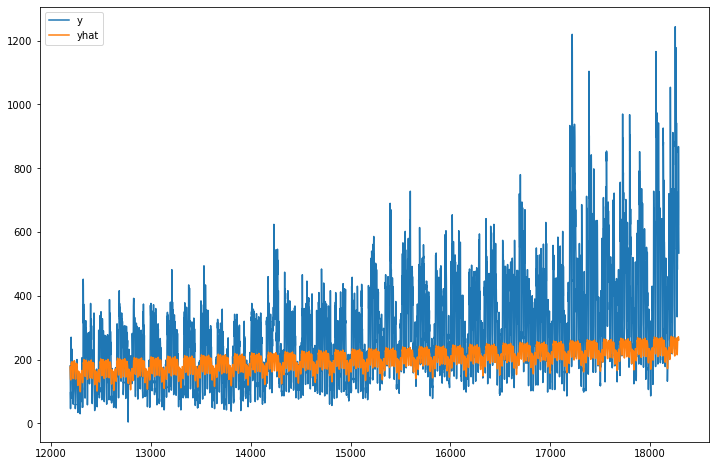

In [121]:
X_test['y'].plot(legend=True)
forecast.loc[12192:, 'yhat'].plot(legend=True)

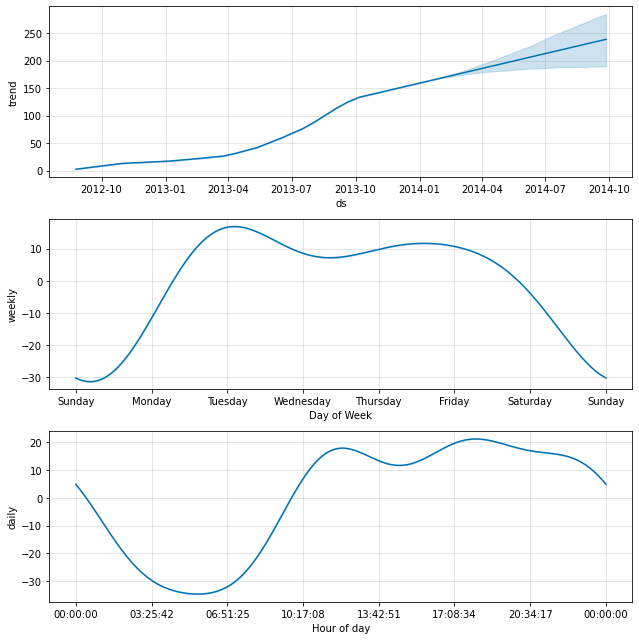

In [122]:
m.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

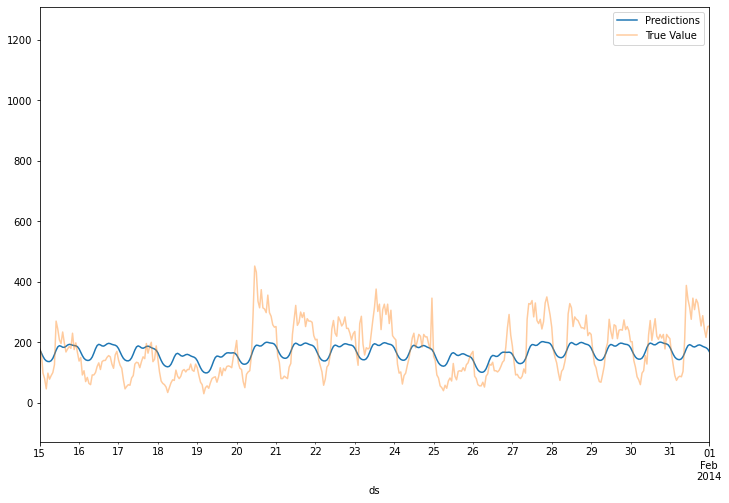

In [129]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

X_test.plot(x='ds',y='y',label='True Value',legend=True,ax=ax,xlim=('2014-01-15','2014-02-01'),alpha=0.4)

In [134]:
forecast.loc[12192:, 'yhat'].astype(int)

12192    176
12193    165
12194    153
12195    144
12196    138
        ... 
18283    270
18284    268
18285    266
18286    265
18287    261
Name: yhat, Length: 6096, dtype: int64

In [135]:
rmse(X_test['y'],forecast.loc[12192:, 'yhat'].astype(int))

163.41423220175542

In [53]:
print('RMSE of ARIMA model',rmse(X_test['y'],forecast.loc[12192:, 'yhat'].astype(int)))
print('MAPE of ARIMA model', mean_absolute_percentage_error(X_test['y'],forecast.loc[12192:, 'yhat'].astype(int)))

RMSE of ARIMA model 163.41423220175542
MAPE of ARIMA model 0.3571927099759109


In [136]:
train_df.head()

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


In [137]:
m =  Prophet()
m.fit(train_df)

In [139]:
test_df.shape+

(5112, 1)

In [140]:
final_future_df = m.make_future_dataframe(periods=5112, freq='H')

In [141]:
final_future_df.tail()

,ds
23395,2015-04-26 19:00:00
23396,2015-04-26 20:00:00
23397,2015-04-26 21:00:00
23398,2015-04-26 22:00:00
23399,2015-04-26 23:00:00


In [142]:
test_df.tail()

,ID
Datetime,
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397
2015-04-26 22:00:00,23398
2015-04-26 23:00:00,23399


In [143]:
final_forecast = m.predict(final_future_df)

In [144]:
test_df.head()

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292


<AxesSubplot:>

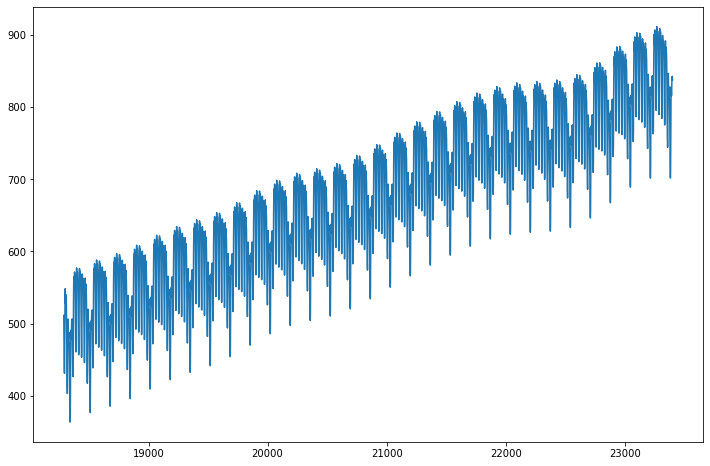

In [151]:
final_forecast.loc[18288:]['yhat'].plot()

In [161]:
sample['Count'] = final_forecast.loc[18288:]['yhat'].astype(int).values

In [163]:
sample.to_csv('FB-Prophet.csv', index=False)